[![](https://img.shields.io/badge/Source%20on%20GitHub-orange)](https://github.com/laminlabs/lamin-spatial/blob/main/docs/vitessce.ipynb) [![hub](https://img.shields.io/badge/View%20on%20LaminHub-mediumseagreen)](https://lamin.ai/laminlabs/lamindata/transform/hqtT4OTr5Tiq5zKv/URbaThYhljgXbZEzgj5x)

# Vitessce

This tutorial has been adopted from the data preparation examples in [the Vitessce documention](https://vitessce.github.io/vitessce-python).

We demonstrate how to use Vitessce to create interactive visualizations for data stored in LaminDB Artifacts, using multiple data formats.

In [ ]:
# !pip install "vitessce[all]>=3.5.0"
# !pip install "generate-tiff-offsets>=0.1.9"
# !pip install "lamindb[jupyter,aws,bionty]"
!lamin connect laminlabs/lamin-dev  # <-- replace with your instance

In [1]:
from urllib.request import urlretrieve
from pathlib import Path
from anndata import read_h5ad
import vitessce as vit
from vitessce import data_utils as vitdu
from generate_tiff_offsets import get_offsets
import lamindb as ln
import zipfile
import json

# [optional] track the current notebook or script
ln.track("BZhZQ6uIbkWv0000")

→ connected lamindb: vitessce/examples
→ created Transform('BZhZQ6uI'), started new Run('wW6GOHDq') at 2024-12-04 16:10:55 UTC
→ notebook imports: anndata==0.10.8 generate-tiff-offsets==0.1.9 lamindb==0.77.2 vitessce==3.5.0


## Visualize an AnnData object (H5AD format)

Here, we download an example H5AD file (approximately 22 MB). This is a [dataset](https://www.covid19cellatlas.org/index.healthy.html#habib17) from the COVID-19 Cell Atlas.

In [2]:
h5ad_raw_filepath = "./habib17.raw.h5ad"
h5ad_processed_filepath = "./habib17.processed.h5ad"
if not Path(h5ad_raw_filepath).exists():
    urlretrieve(
        "https://covid19.cog.sanger.ac.uk/habib17.processed.h5ad", h5ad_raw_filepath
    )

This AnnData file was not saved recently and `read_h5ad` will warn us about this. By reading and subsequently re-writing the file using an up-to-date `anndata` package version, we ensure that the dataset is saved using the latest AnnData H5AD format.

In [3]:
adata = read_h5ad(h5ad_raw_filepath)

/Users/markkeller/research/dbmi/vitessce/lamin/hello-world/.venv/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/markkeller/research/dbmi/vitessce/lamin/hello-world/.venv/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Optionally, we can modify the AnnData object, for example to subset it to the highly variable genes (which will affect the amount of data that is displayed in the heatmap visualization).

In [4]:
adata = adata[:, adata.var["highly_variable"]].copy()

In [5]:
adata.write_h5ad(h5ad_processed_filepath)

### Save the dataset

Save the `.h5ad` file as a LaminDB Artifact.

In [6]:
h5ad_artifact = ln.Artifact(
    h5ad_processed_filepath,
    key="vitessce_examples/habib17.h5ad",
    description="Habib et al., 2017 Nature Methods, h5ad",
    type="dataset",
)
h5ad_artifact.save()

→ returning existing artifact with same hash: Artifact(uid='1g3a41z0hggWNBrk0000', is_latest=True, key='vitessce_examples/habib17.h5ad', description='Habib et al., 2017 Nature Methods, h5ad', suffix='.h5ad', type='dataset', size=22586523, hash='-O1gvNOMqXm96TNFJ4yZXQ', _hash_type='md5', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-12-03 21:31:03 UTC)


Artifact(uid='1g3a41z0hggWNBrk0000', is_latest=True, key='vitessce_examples/habib17.h5ad', description='Habib et al., 2017 Nature Methods, h5ad', suffix='.h5ad', type='dataset', size=22586523, hash='-O1gvNOMqXm96TNFJ4yZXQ', _hash_type='md5', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-03 21:31:03 UTC)

When using `.h5ad` files, we construct a [Reference Specification](https://fsspec.github.io/kerchunk/spec.html) which enables interoperability with the [Zarr](https://zarrita.dev/packages/storage.html#referencestore) interface.

In [7]:
ref_spec = vitdu.generate_h5ad_ref_spec(h5ad_processed_filepath)

We next need to save the corresponding Reference Specification to a JSON file and upload it to LaminDB as an Artifact.

In [8]:
ref_path = "./habib17.processed.reference.json"
with open(ref_path, "w") as file:
    json.dump(ref_spec, file)
ref_artifact = ln.Artifact(
    ref_path,
    key="vitessce_examples/habib17.reference.json",
    description="Reference JSON for H5AD file, Habib et al., 2017 Nature Methods"
).save()

→ returning existing artifact with same hash: Artifact(uid='O7CTVi6XjnfsceQ20000', is_latest=True, key='vitessce_examples/habib17.reference.json', description='Reference JSON for H5AD file, Habib et al., 2017 Nature Methods', suffix='.json', size=543575, hash='XFOV2X6Bw6_zTugTOEBehg', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-12-03 21:31:14 UTC)


### Save a VitessceConfig object

You can create a dashboard for one or several datasets by using Vitessce's component API.

You can pass LaminDB Artifacts to the AnnDataWrapper class using the `adata_artifact` and `ref_artifact` [parameters](https://python-docs.vitessce.io/api_data.html#vitessce.wrappers.AnnDataWrapper).

In [9]:
vc = vit.VitessceConfig(
    schema_version="1.0.17",
    description=h5ad_artifact.description,
)
dataset = vc.add_dataset(name="Habib 2017").add_object(
    vit.AnnDataWrapper(
        adata_artifact=h5ad_artifact,
        ref_artifact=ref_artifact,
        obs_feature_matrix_path="X",
        obs_embedding_paths=["obsm/X_umap"],
        obs_embedding_names=["UMAP"],
        obs_set_paths=["obs/CellType"],
        obs_set_names=["Cell Type"],
    )
)
obs_sets = vc.add_view(vit.ViewType.OBS_SETS, dataset=dataset)
obs_sets_sizes = vc.add_view(vit.ViewType.OBS_SET_SIZES, dataset=dataset)
scatterplot = vc.add_view(vit.ViewType.SCATTERPLOT, dataset=dataset, mapping="UMAP")
heatmap = vc.add_view(vit.ViewType.HEATMAP, dataset=dataset)
genes = vc.add_view(vit.ViewType.FEATURE_LIST, dataset=dataset)
vc.link_views([scatterplot, heatmap], ["featureValueColormapRange"], [[0.0, 0.1]])
vc.layout(((scatterplot | obs_sets) / heatmap) | (obs_sets_sizes / genes));

Save the `VitessceConfig` object.

In [10]:
h5ad_vc_artifact = ln.integrations.save_vitessce_config(
    vc, description="View Habib17 (h5ad) in Vitessce",
)

→ VitessceConfig references these artifacts:
Artifact(uid='1g3a41z0hggWNBrk0000', is_latest=True, key='vitessce_examples/habib17.h5ad', description='Habib et al., 2017 Nature Methods, h5ad', suffix='.h5ad', type='dataset', size=22586523, hash='-O1gvNOMqXm96TNFJ4yZXQ', _hash_type='md5', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-03 21:31:03 UTC)
Artifact(uid='O7CTVi6XjnfsceQ20000', is_latest=True, key='vitessce_examples/habib17.reference.json', description='Reference JSON for H5AD file, Habib et al., 2017 Nature Methods', suffix='.json', size=543575, hash='XFOV2X6Bw6_zTugTOEBehg', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-03 21:31:14 UTC)
! returning existing collection with same hash: Collection(uid='obXokdzOnSH2tytJ0000', is_latest=True, name='View Habib17 (h5ad) in Vitessce', hash='U9WUAN_l9mLUWYqO2pJ9-g'

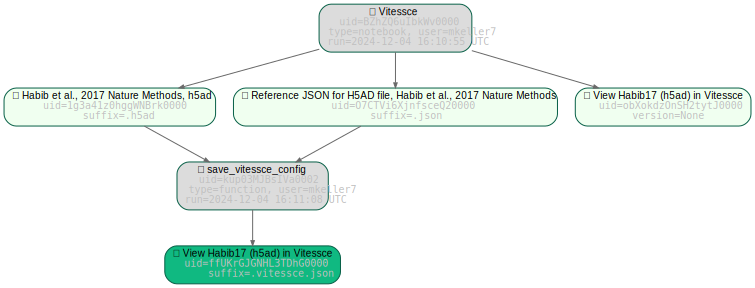

In [11]:
h5ad_vc_artifact.view_lineage()

:::{note}

After running `save_vitessce_config`, a Vitessce button will appear next to the dataset in the [Artifacts](https://lamin.ai/vitessce/examples/artifacts) page of the web interface.

If your `VitessceConfig` object references data from multiple artifacts, the Vitessce button will appear next to a `Collection` that groups these artifacts (on the [Collections](https://lamin.ai/vitessce/examples/collections) tab of the Artifacts page).
Note that when using an `.h5ad`-based Artifact, the presence of the corresponding `.reference.json` file will result in the creation of a Collection.

:::

## Visualize an AnnData object (Zarr format)

AnnData objects can be saved on-disk to not only `.h5ad` files, but also to [Zarr stores](https://zarr.readthedocs.io/en/stable/tutorial.html#storage-alternatives) using AnnData's [write_zarr](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.write_zarr.html) method.

### Save the dataset

Convert the dataset to `.zarr` format. Often, Zarr data is stored on-disk using a [DirectoryStore](https://zarr.readthedocs.io/en/stable/api/storage.html#zarr.storage.DirectoryStore). By convention, these directories are named using a `.zarr` suffix.

In [12]:
zarr_processed_filepath = "./habib17.anndata.zarr"

In [13]:
adata = read_h5ad(h5ad_raw_filepath)

/Users/markkeller/research/dbmi/vitessce/lamin/hello-world/.venv/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/Users/markkeller/research/dbmi/vitessce/lamin/hello-world/.venv/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Just like in the above section, we may want to modify the AnnData object prior to saving it as a LaminDB Artifact that we will use for visualization.

In [14]:
adata = adata[:, adata.var["highly_variable"]].copy()

Note the usage of `.write_zarr` below, as opposed to `.write_h5ad`.

In [15]:
adata.write_zarr(zarr_processed_filepath)

Save the `.zarr` directory as a LaminDB Artifact.

In [16]:
adata_zarr_artifact = ln.Artifact(
    zarr_processed_filepath,
    key="vitessce_examples/habib17.adata.zarr",
    description="Habib et al., 2017 Nature Methods, zarr",
    type="dataset",
)
adata_zarr_artifact.save()

→ returning existing artifact with same hash: Artifact(uid='kWwG45Hr26KZUW3g0004', is_latest=True, key='vitessce_examples/habib17.adata.zarr', description='Habib et al., 2017 Nature Methods, zarr', suffix='.anndata.zarr', type='dataset', size=10601062, hash='Ap_EL5yPdfyD07Xjpe1SlA', n_objects=208, _hash_type='md5-d', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-12-04 16:01:11 UTC)


Artifact(uid='kWwG45Hr26KZUW3g0004', is_latest=True, key='vitessce_examples/habib17.adata.zarr', description='Habib et al., 2017 Nature Methods, zarr', suffix='.anndata.zarr', type='dataset', size=10601062, hash='Ap_EL5yPdfyD07Xjpe1SlA', n_objects=208, _hash_type='md5-d', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 16:01:11 UTC)

### Save a VitessceConfig object

You can create a dashboard for one or several datasets by using Vitessce's component API.
Here, we configure the visualization the same way as above in the `.h5ad`-based example, with the exception of the `ref_artifact` parameter, as `.zarr`-based AnnData objects do not require a Reference Specification for Zarr interoperability.

In [17]:
vc = vit.VitessceConfig(
    schema_version="1.0.17",
    description=adata_zarr_artifact.description,
)
dataset = vc.add_dataset(name="Habib 2017").add_object(
    vit.AnnDataWrapper(
        adata_artifact=adata_zarr_artifact,
        obs_feature_matrix_path="X",
        obs_embedding_paths=["obsm/X_umap"],
        obs_embedding_names=["UMAP"],
        obs_set_paths=["obs/CellType"],
        obs_set_names=["Cell Type"],
    )
)
obs_sets = vc.add_view(vit.Component.OBS_SETS, dataset=dataset)
obs_sets_sizes = vc.add_view(vit.Component.OBS_SET_SIZES, dataset=dataset)
scatterplot = vc.add_view(vit.Component.SCATTERPLOT, dataset=dataset, mapping="UMAP")
heatmap = vc.add_view(vit.Component.HEATMAP, dataset=dataset)
genes = vc.add_view(vit.Component.FEATURE_LIST, dataset=dataset)
vc.link_views([scatterplot, heatmap], ["featureValueColormapRange"], [[0.0, 0.1]])
vc.layout(((scatterplot | obs_sets) / heatmap) | (obs_sets_sizes / genes));

Save the `VitessceConfig` object.

In [18]:
adata_zarr_vc_artifact = ln.integrations.save_vitessce_config(
    vc, description="View Habib17 in Vitessce",
)

→ VitessceConfig references these artifacts:
Artifact(uid='kWwG45Hr26KZUW3g0004', is_latest=True, key='vitessce_examples/habib17.adata.zarr', description='Habib et al., 2017 Nature Methods, zarr', suffix='.anndata.zarr', type='dataset', size=10601062, hash='Ap_EL5yPdfyD07Xjpe1SlA', n_objects=208, _hash_type='md5-d', _accessor='AnnData', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 16:01:11 UTC)
→ returning existing artifact with same hash: Artifact(uid='J4tMB6qAeHvsgEsp0000', is_latest=True, description='View Habib17 in Vitessce', suffix='.vitessce.json', size=1247, hash='MN-N-I_cn9K8Y2Pe59u1Fw', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=15, run_id=81, created_by_id=2, created_at=2024-12-04 14:32:11 UTC)
→ VitessceConfig: https://lamin.ai/vitessce/examples/artifact/J4tMB6qAeHvsgEsp0000
→ Dataset: https://lamin.ai/vitessce/examples/artifact/kWwG45Hr26KZUW3g0004


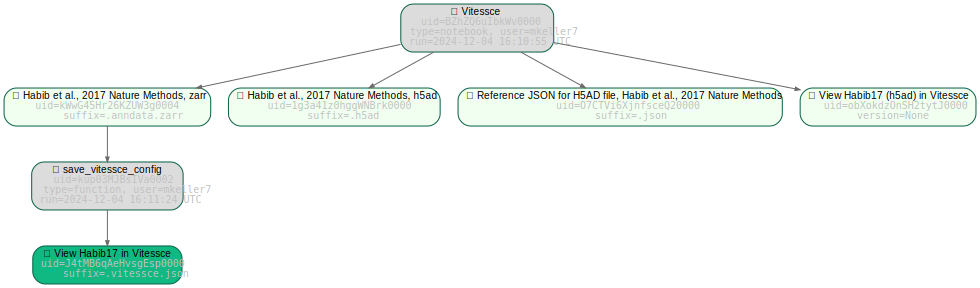

In [19]:
adata_zarr_vc_artifact.view_lineage()

:::{note}

After running `save_vitessce_config`, a Vitessce button will appear next to the dataset in the [Artifacts](https://lamin.ai/vitessce/examples/artifacts) page of the web interface.

:::

## Visualize a SpatialData object (Zarr format)

Download and unzip the example SpatialData dataset (approximately 1.47 GB unzipped). Once unzipped, the data will be available via a local Zarr DirectoryStore.

In [20]:
sdata_zip_filepath = "./visium.spatialdata.zarr.zip"
sdata_zarr_filepath = "./visium.spatialdata.zarr"
if not Path(sdata_zarr_filepath).exists():
    if not Path(sdata_zip_filepath).exists():
        urlretrieve(
            "https://s3.embl.de/spatialdata/spatialdata-sandbox/visium_associated_xenium_io.zip",
            sdata_zip_filepath,
        )
    with zipfile.ZipFile(sdata_zip_filepath, "r") as zip_ref:
        zip_ref.extractall(".")
        Path("data.zarr").rename(sdata_zarr_filepath)

### Save the dataset

Save the `.zarr` DirectoryStore as a LaminDB Artifact.

In [21]:
sdata_zarr_artifact = ln.Artifact(
    sdata_zarr_filepath,
    key="vitessce_examples/visium.sdata.zarr",
    description="Visium SpatialData Example",
    type="dataset",
)
sdata_zarr_artifact.save()

→ returning existing artifact with same hash: Artifact(uid='nelDyBfwvEIIAKcC0000', is_latest=True, key='vitessce_examples/visium.sdata.zarr', description='Visium SpatialData Example', suffix='.zarr', type='dataset', size=1473180201, hash='BkflAMTiin88wE3Wc84rDQ', n_objects=9167, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-12-04 13:25:22 UTC)


Artifact(uid='nelDyBfwvEIIAKcC0000', is_latest=True, key='vitessce_examples/visium.sdata.zarr', description='Visium SpatialData Example', suffix='.zarr', type='dataset', size=1473180201, hash='BkflAMTiin88wE3Wc84rDQ', n_objects=9167, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 13:25:22 UTC)

### Save a VitessceConfig object

You can create a dashboard for one or several datasets by using Vitessce's component API.
Here, we use the [SpatialDataWrapper](https://python-docs.vitessce.io/api_data.html#vitessce.wrappers.SpatialDataWrapper) class to specify which parts of the SpatialData object will be loaded for visualization.

In [22]:
vc = vit.VitessceConfig(
    schema_version="1.0.17",
    description=sdata_zarr_artifact.description,
)
# Add data to the configuration:
dataset_uid = "sdata_visium"
dataset = vc.add_dataset(name='Breast Cancer Visium', uid=dataset_uid).add_object(
    vit.SpatialDataWrapper(
        sdata_artifact=sdata_zarr_artifact,
        # The following paths are relative to the root of the SpatialData zarr store on-disk.
        image_path="images/CytAssist_FFPE_Human_Breast_Cancer_full_image",
        table_path="tables/table",
        obs_feature_matrix_path="tables/table/X",
        obs_spots_path="shapes/CytAssist_FFPE_Human_Breast_Cancer",
        region="CytAssist_FFPE_Human_Breast_Cancer",
        coordinate_system="global",
        coordination_values={
            # The following tells Vitessce to consider each observation as a "spot"
            "obsType": "spot",
        },
    )
)

# Add views (visualizations) to the configuration:
spatial = vc.add_view("spatialBeta", dataset=dataset)
feature_list = vc.add_view("featureList", dataset=dataset)
layer_controller = vc.add_view("layerControllerBeta", dataset=dataset)

# Initialize visual properties for multiple linked views:
vc.link_views_by_dict([spatial, layer_controller], {
    "imageLayer": vit.CoordinationLevel([{
        "photometricInterpretation": "RGB",
    }]),
}, scope_prefix=vit.get_initial_coordination_scope_prefix(dataset_uid, "image"))
vc.link_views([spatial, layer_controller, feature_list, obs_sets], ["obsType"], ["spot"])

# Layout the views
vc.layout(spatial | (feature_list / layer_controller));

Save the `VitessceConfig` object.

In [23]:
sdata_vc_artifact = ln.integrations.save_vitessce_config(
    vc, description="View Visium SpatialData Example in Vitessce",
)

→ VitessceConfig references these artifacts:
Artifact(uid='nelDyBfwvEIIAKcC0000', is_latest=True, key='vitessce_examples/visium.sdata.zarr', description='Visium SpatialData Example', suffix='.zarr', type='dataset', size=1473180201, hash='BkflAMTiin88wE3Wc84rDQ', n_objects=9167, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 13:25:22 UTC)
→ returning existing artifact with same hash: Artifact(uid='Xot2a5ZAcTW3fClG0000', is_latest=True, description='View Visium SpatialData Example in Vitessce', suffix='.vitessce.json', size=1845, hash='PirnTDMPxYDC9ajti_St4g', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=15, run_id=82, created_by_id=2, created_at=2024-12-04 15:53:06 UTC)
→ VitessceConfig: https://lamin.ai/vitessce/examples/artifact/Xot2a5ZAcTW3fClG0000
→ Dataset: https://lamin.ai/vitessce/examples/artifact/nelDyBfwvEIIAKcC0000


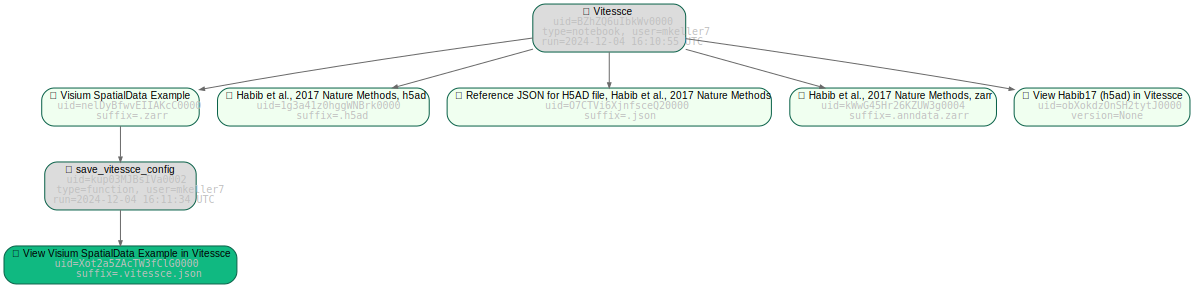

In [24]:
sdata_vc_artifact.view_lineage()

:::{note}

After running `save_vitessce_config`, a Vitessce button will appear next to the dataset in the [Artifacts](https://lamin.ai/vitessce/examples/artifacts) page of the web interface.

:::

## Visualize an image (OME-TIFF format)

Vitesse can visualize data from multiple bioimaging file formats, including [OME-TIFF](https://ome-model.readthedocs.io/en/stable/ome-tiff/).

Here, we download an example OME-TIFF file (approximately 1.02 GB).

In [25]:
ome_tiff_filepath = "./VAN0006-LK-2-85-PAS_registered.ome.tif"
if not Path(ome_tiff_filepath).exists():
    urlretrieve(
        "https://assets.hubmapconsortium.org/f4188a148e4c759092d19369d310883b/ometiff-pyramids/processedMicroscopy/VAN0006-LK-2-85-PAS_images/VAN0006-LK-2-85-PAS_registered.ome.tif",
        ome_tiff_filepath,
    )

### Save the dataset

Save the `.ome.tif` file as a LaminDB Artifact.

In [26]:
ome_tiff_artifact = ln.Artifact(
    ome_tiff_filepath,
    key="vitessce_examples/VAN0006-LK-2-85-PAS_registered.ome.tif",
    description="PAS OME-TIFF file, Neumann et al., 2020",
    type="dataset",
)
ome_tiff_artifact.save()

→ returning existing artifact with same hash: Artifact(uid='0I5aMNdh2UrECtFX0000', is_latest=True, key='vitessce_examples/VAN0006-LK-2-85-PAS_registered.ome.tif', description='PAS OME-TIFF file, Neumann et al., 2020', suffix='.tif', type='dataset', size=1021561156, hash='pa3FYqKL6afG8PduprhRJk', _hash_type='sha1-fl', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-10-05 20:00:49 UTC)


Artifact(uid='0I5aMNdh2UrECtFX0000', is_latest=True, key='vitessce_examples/VAN0006-LK-2-85-PAS_registered.ome.tif', description='PAS OME-TIFF file, Neumann et al., 2020', suffix='.tif', type='dataset', size=1021561156, hash='pa3FYqKL6afG8PduprhRJk', _hash_type='sha1-fl', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-10-05 20:00:49 UTC)

When using OME-TIFF files, we can use [generate-tiff-offsets](https://github.com/hms-dbmi/generate-tiff-offsets) to create an index for the bytes within the OME-TIFF file. We store these to a companion `.offsets.json` file which makes loading subsets of the image more efficient.

In [27]:
offsets = get_offsets(ome_tiff_filepath)

In [28]:
offsets_path = "./VAN0006-LK-2-85-PAS_registered.offsets.json"
with open(offsets_path, "w") as file:
    json.dump(offsets, file)
offsets_artifact = ln.Artifact(
    offsets_path,
    key="vitessce_examples/VAN0006-LK-2-85-PAS_registered.offsets.json",
    description="PAS offsets file, Neumann et al., 2020"
).save()

→ returning existing artifact with same hash: Artifact(uid='CMBUzbNNCEDGCKcQ0000', is_latest=True, key='vitessce_examples/VAN0006-LK-2-85-PAS_registered.offsets.json', description='PAS offsets file, Neumann et al., 2020', suffix='.json', type='dataset', size=36, hash='5ADv5d7DI5oYVaMOPnhqiw', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-10-05 20:18:38 UTC)


### Save a VitessceConfig object

You can create a dashboard for one or several datasets by using Vitessce's component API.
Here, we use the [ImageOmeTiffWrapper](https://python-docs.vitessce.io/api_data.html#vitessce.wrappers.ImageOmeTiffWrapper) class to specify which pair of OME-TIFF file and offsets JSON file to load.

In [29]:
vc = vit.VitessceConfig(
    schema_version="1.0.17",
    description=ome_tiff_artifact.description
)
dataset = vc.add_dataset("Image").add_object(
    vit.ImageOmeTiffWrapper(
        img_artifact=ome_tiff_artifact,
        offsets_artifact=offsets_artifact,
    )
)
spatial = vc.add_view("spatialBeta", dataset=dataset)
layer_controller = vc.add_view("layerControllerBeta", dataset=dataset)
vc.layout(spatial | layer_controller);

Save the `VitessceConfig` object.

In [30]:
ome_tiff_vc_artifact = ln.integrations.save_vitessce_config(
    vc, description="View PAS OME-TIFF, Neumann et al., 2020 in Vitessce",
)

→ VitessceConfig references these artifacts:
Artifact(uid='0I5aMNdh2UrECtFX0000', is_latest=True, key='vitessce_examples/VAN0006-LK-2-85-PAS_registered.ome.tif', description='PAS OME-TIFF file, Neumann et al., 2020', suffix='.tif', type='dataset', size=1021561156, hash='pa3FYqKL6afG8PduprhRJk', _hash_type='sha1-fl', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-10-05 20:00:49 UTC)
Artifact(uid='CMBUzbNNCEDGCKcQ0000', is_latest=True, key='vitessce_examples/VAN0006-LK-2-85-PAS_registered.offsets.json', description='PAS offsets file, Neumann et al., 2020', suffix='.json', type='dataset', size=36, hash='5ADv5d7DI5oYVaMOPnhqiw', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-10-05 20:18:38 UTC)
! returning existing collection with same hash: Collection(uid='HqfzZmkfYOy20ZNN0000', is_latest=True, name='View PAS OME-TIFF, Neumann et al., 2020 in Vi

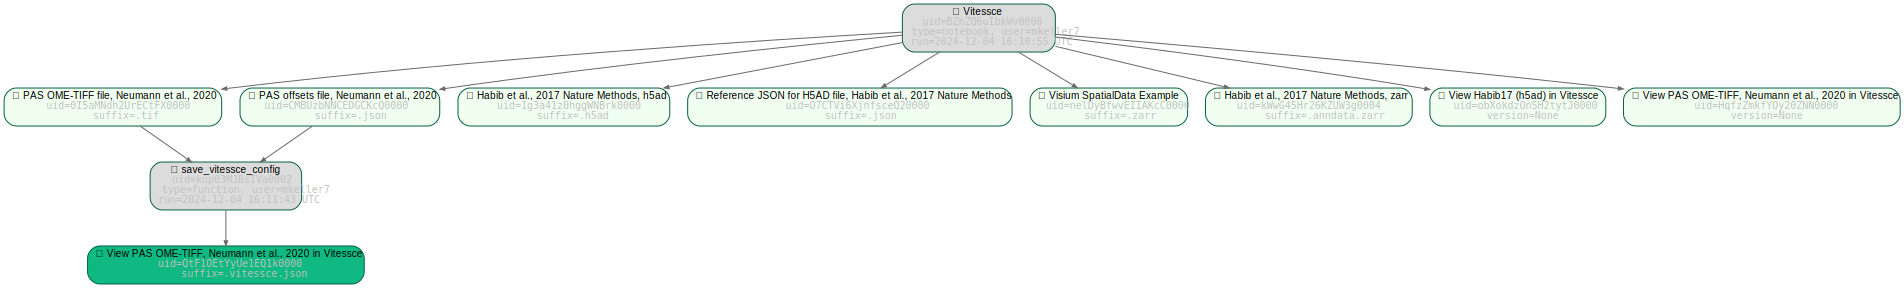

In [31]:
ome_tiff_vc_artifact.view_lineage()

:::{note}

After running `save_vitessce_config`, a Vitessce button will appear next to the dataset in the [Artifacts](https://lamin.ai/vitessce/examples/artifacts) page of the web interface.

If your `VitessceConfig` object references data from multiple artifacts, the Vitessce button will appear next to a `Collection` that groups these artifacts (on the [Collections](https://lamin.ai/vitessce/examples/collections) tab of the Artifacts page).
In the case of OME-TIFF, the presence of the corresponding offsets JSON file will result in the creation of a Collection.

:::

## Visualize an image (OME-Zarr format)

Retrieve an OME-Zarr (also known as OME-NGFF) formatted image. We could download an unzip such an image, but in downloading the SpatialData object above, we already have access to a valid OME-Zarr image locally.

In [32]:
ome_zarr_filepath = Path(sdata_zarr_filepath) / "images" / "CytAssist_FFPE_Human_Breast_Cancer_full_image"

### Save the dataset

Save the `.ome.zarr` DirectoryStore as a LaminDB Artifact.

In [33]:
ome_zarr_artifact = ln.Artifact(
    ome_zarr_filepath,
    key="vitessce_examples/visium.ome.zarr",
    description="Visium OME-Zarr Example",
    type="dataset",
)
ome_zarr_artifact.save()

→ returning existing artifact with same hash: Artifact(uid='toCvpsqAiH3XcAvT0000', is_latest=True, key='vitessce_examples/visium.ome.zarr', description='Visium OME-Zarr Example', suffix='', type='dataset', size=1400251840, hash='UtsNOkk05EFL34hgUabEwg', n_objects=8809, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=17, run_id=79, created_by_id=2, created_at=2024-12-04 14:38:29 UTC)


Artifact(uid='toCvpsqAiH3XcAvT0000', is_latest=True, key='vitessce_examples/visium.ome.zarr', description='Visium OME-Zarr Example', suffix='', type='dataset', size=1400251840, hash='UtsNOkk05EFL34hgUabEwg', n_objects=8809, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 14:38:29 UTC)

### Save a VitessceConfig object

You can create a dashboard for one or several datasets by using Vitessce's component API.
Here, we use the [ImageOmeZarrWrapper](https://python-docs.vitessce.io/api_data.html#vitessce.wrappers.ImageOmeZarrWrapper) class to specify an OME-Zarr file to load for visualization.

In [34]:
vc = vit.VitessceConfig(
    schema_version="1.0.17",
    description=ome_zarr_artifact.description
)
dataset_uid = "ome_zarr_image"
dataset = vc.add_dataset("Image", uid=dataset_uid).add_object(
    vit.ImageOmeZarrWrapper(
        img_artifact=ome_zarr_artifact,
    )
)
spatial = vc.add_view("spatialBeta", dataset=dataset)
layer_controller = vc.add_view("layerControllerBeta", dataset=dataset)
vc.link_views_by_dict([spatial, layer_controller], {
    "imageLayer": vit.CoordinationLevel([{
        "photometricInterpretation": "RGB",
    }]),
}, scope_prefix=vit.get_initial_coordination_scope_prefix(dataset_uid, "image"))
vc.layout(spatial | layer_controller);

Save the `VitessceConfig` object.

In [35]:
ome_zarr_vc_artifact = ln.integrations.save_vitessce_config(
    vc, description="View Visium OME-Zarr Example in Vitessce",
)

→ VitessceConfig references these artifacts:
Artifact(uid='toCvpsqAiH3XcAvT0000', is_latest=True, key='vitessce_examples/visium.ome.zarr', description='Visium OME-Zarr Example', suffix='', type='dataset', size=1400251840, hash='UtsNOkk05EFL34hgUabEwg', n_objects=8809, _hash_type='md5-d', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=18, run_id=85, created_by_id=2, created_at=2024-12-04 14:38:29 UTC)
→ returning existing artifact with same hash: Artifact(uid='cjvX6EFrdSwsxOQl0000', is_latest=True, description='View Visium OME-Zarr Example in Vitessce', suffix='.vitessce.json', size=1240, hash='PiQa8hZ7nphs4FoTdhOwxg', _hash_type='md5', visibility=1, _key_is_virtual=True, storage_id=1, transform_id=15, run_id=84, created_by_id=2, created_at=2024-12-04 15:53:20 UTC)
→ VitessceConfig: https://lamin.ai/vitessce/examples/artifact/cjvX6EFrdSwsxOQl0000
→ Dataset: https://lamin.ai/vitessce/examples/artifact/toCvpsqAiH3XcAvT0000


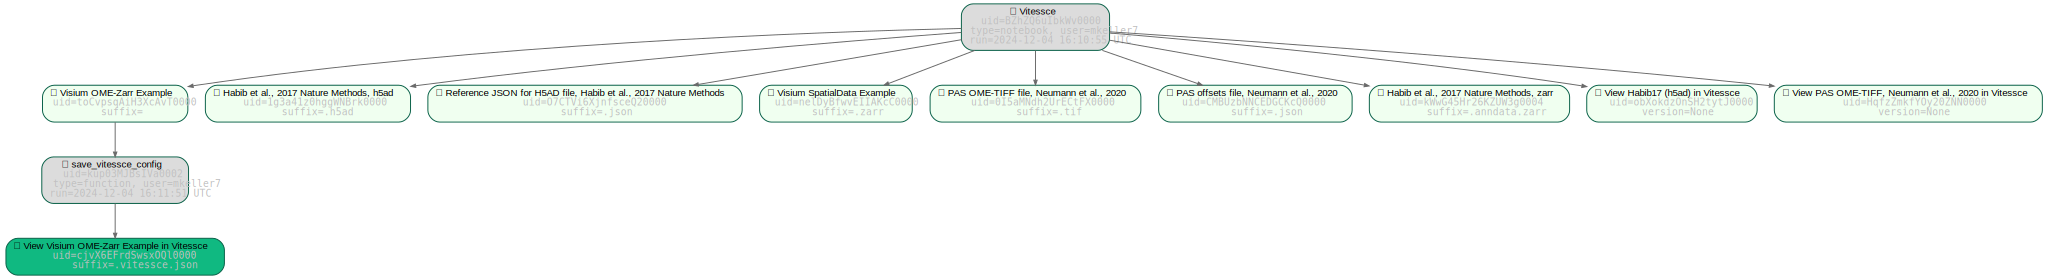

In [36]:
ome_zarr_vc_artifact.view_lineage()

:::{note}

After running `save_vitessce_config`, a Vitessce button will appear next to the dataset in the [Artifacts](https://lamin.ai/vitessce/examples/artifacts) page of the web interface.

:::

In [38]:
# [optional] finish run context and auto-save the notebook
ln.finish()

! cells [(0, None), (None, 1)] were not run consecutively


   Do you still want to proceed with finishing? (y/n)  y


→ finished Run('wW6GOHDq') after 0d 0h 1m 9s at 2024-12-04 16:12:04 UTC
→ go to: https://lamin.ai/vitessce/examples/transform/BZhZQ6uIbkWv0000
→ if you want to update your notebook without re-running it, use `lamin save /Users/markkeller/research/dbmi/vitessce/lamin/lamin-spatial/docs/vitessce.ipynb`


:::{dropdown} Upload speed

Here is [a note](https://lamin.ai/laminlabs/lamindata/transform/WDjio16cQsdW5zKv) on folder upload speed and why `lamindb` does not use the `.export(to="s3")` functionality of Vitessce.

:::

In [ ]:
# clean up artifacts in CI run
h5ad_artifact.delete(permanent=True)
ref_artifact.delete(permanent=True)

adata_zarr_artifact.delete(permanent=True)
sdata_zarr_artifact.delete(permanent=True)

ome_tiff_artifact.delete(permanent=True)
offsets_artifact.delete(permanent=True)

ome_zarr_artifact.delete(permanent=True)

h5ad_vc_artifact.delete(permanent=True)
adata_zarr_vc_artifact.delete(permanent=True)
sdata_vc_artifact.delete(permanent=True)
ome_tiff_vc_artifact.delete(permanent=True)
ome_zarr_vc_artifact.delete(permanent=True)